In [4]:
# CELL 1: Add this at the beginning of your notebook
# ======== GPU Configuration and Optimization ===========
import tensorflow as tf
import os
import numpy as np

# Check GPU availability and configure
def setup_gpu():
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        try:
            # Set memory growth for all GPUs
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            
            # Log GPU information
            logical_gpus = tf.config.list_logical_devices('GPU')
            print(f"Physical GPUs: {len(gpus)}, Logical GPUs: {len(logical_gpus)}")
            print(f"Using GPU: {tf.test.gpu_device_name()}")
            return True
        except RuntimeError as e:
            print(e)
            return False
    else:
        print("No GPU found. Running on CPU.")
        return False

# Enable mixed precision for faster training on GPU
def enable_mixed_precision():
    policy = tf.keras.mixed_precision.Policy('mixed_float16')
    tf.keras.mixed_precision.set_global_policy(policy)
    print('Mixed precision enabled:')
    print('  Compute dtype:', policy.compute_dtype)
    print('  Variable dtype:', policy.variable_dtype)

# Run GPU setup
print("Checking GPU availability...")
is_gpu_available = setup_gpu()

# Enable mixed precision if GPU is available
if is_gpu_available:
    enable_mixed_precision()

# Print TensorFlow version and GPU information
print("\nTensorFlow version:", tf.__version__)
print("Is GPU available:", tf.test.is_gpu_available())
print("GPU device name:", tf.test.gpu_device_name())

Checking GPU availability...
Physical GPUs: 1, Logical GPUs: 1
Using GPU: /device:GPU:0
Mixed precision enabled:
  Compute dtype: float16
  Variable dtype: float32

TensorFlow version: 2.17.1
Is GPU available: True
GPU device name: /device:GPU:0


In [5]:
import tensorflow as tf
import os
import numpy as np

# Define dataset paths (adjust BASE_PATH if necessary)
BASE_PATH = "/kaggle/input/xbd-dataset/xbd/tier3"
IMAGES_PATH = os.path.join(BASE_PATH, "images")
MASKS_PATH = os.path.join(BASE_PATH, "masks")


In [6]:
# List image and mask filenames
image_names = sorted([fname for fname in os.listdir(IMAGES_PATH) 
                      if (fname.endswith('.png') or fname.endswith('.jpg')) and "pre_disaster" in fname])
mask_names = sorted([fname for fname in os.listdir(MASKS_PATH) 
                     if (fname.endswith('.png') or fname.endswith('.jpg')) and "pre_disaster" in fname])

# Find common file names between images and masks (based on names)
common_names = sorted(list(set(image_names).intersection(set(mask_names))))
print("Number of common pre-disaster files:", len(common_names))

# Create full paths for matching pre-disaster files
image_files = [os.path.join(IMAGES_PATH, fname) for fname in common_names]
mask_files = [os.path.join(MASKS_PATH, fname) for fname in common_names]


Number of common pre-disaster files: 6369


In [8]:
# Parsing function: Read, decode, resize, and normalize images and masks
def parse_image_mask(image_path, mask_path):
    # Read and decode image (disable animation expansion and set shape)
    image = tf.io.read_file(image_path)
    image = tf.image.decode_image(image, channels=3, expand_animations=False)
    image.set_shape([None, None, 3])
    image = tf.image.resize(image, [512, 512])
    image = tf.cast(image, tf.float32) / 255.0
    
    # Read and decode mask; use nearest neighbor resizing for segmentation
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_image(mask, channels=1, expand_animations=False)
    mask.set_shape([None, None, 1])
    mask = tf.image.resize(mask, [512, 512], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    # Normalize mask to [0,1] (assumes mask pixel values are 0 or 255)
    mask = tf.cast(mask, tf.float32) / 255.0  
    return image, mask

# Data augmentation: horizontal/vertical flips, rotations, brightness adjustment
def augment(image, mask):
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        mask = tf.image.flip_left_right(mask)
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_up_down(image)
        mask = tf.image.flip_up_down(mask)
    k = tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
    image = tf.image.rot90(image, k=k)
    mask = tf.image.rot90(mask, k=k)
    image = tf.image.random_brightness(image, max_delta=0.1)
    return image, mask


In [9]:
# Create a dataset from the common file paths
dataset = tf.data.Dataset.from_tensor_slices((image_files, mask_files))
dataset = dataset.map(parse_image_mask, num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.batch(4).prefetch(tf.data.AUTOTUNE)

# Quick check: Print one batch shape
for images, masks in dataset.take(1):
    print("Images shape:", images.shape, "Masks shape:", masks.shape)


Images shape: (4, 512, 512, 3) Masks shape: (4, 512, 512, 1)


In [10]:
def conv_block(inputs, num_filters):
    x = tf.keras.layers.Conv2D(num_filters, (3, 3), padding='same')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2D(num_filters, (3, 3), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    return x

def encoder_block(inputs, num_filters, dropout_rate=0.1):
    x = conv_block(inputs, num_filters)
    p = tf.keras.layers.MaxPooling2D((2, 2))(x)
    p = tf.keras.layers.Dropout(dropout_rate)(p)
    return x, p

def decoder_block(inputs, skip_features, num_filters):
    x = tf.keras.layers.Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(inputs)
    x = tf.keras.layers.concatenate([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def unet_model(input_size=(512, 512, 3)):
    inputs = tf.keras.Input(input_size)
    
    s1, p1 = encoder_block(inputs, 64, dropout_rate=0.1)
    s2, p2 = encoder_block(p1, 128, dropout_rate=0.1)
    s3, p3 = encoder_block(p2, 256, dropout_rate=0.2)
    s4, p4 = encoder_block(p3, 512, dropout_rate=0.2)
    
    b1 = conv_block(p4, 1024)
    
    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)
    
    outputs = tf.keras.layers.Conv2D(1, (1, 1), padding='same', activation='sigmoid')(d4)
    model = tf.keras.Model(inputs, outputs, name="U-Net")
    return model

model = unet_model()
model.summary()


Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 512, 512, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cast (Cast)               │ (None, 512, 512, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 512, 512, 64)   │          1,792 │ cast[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 512, 512, 64)   │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 512, 512, 64)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 512, 512, 64)   │         36,928 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 512, 512, 64)   │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 512, 512, 64)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 256, 256, 64)   │              0 │ activation_1[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 256, 256, 64)   │              0 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 256, 256, 128)  │         73,856 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 256, 256, 128)  │            512 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 256, 256, 128)  │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 256, 256, 128)  │        147,584 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 256, 256, 128)  │            512 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 256, 256, 128)  │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 128, 128, 128)  │              0 │ activation_3[0][0]     │
│ (MaxPooling2D)       

 Total params: 31,055,297 (118.47 MB)

 Trainable params: 31,043,521 (118.42 MB)

 Non-trainable params: 11,776 (46.00 KB)

In [13]:
def weighted_bce_loss(y_true, y_pred, weight=15):
    epsilon = 1e-7
    y_pred = tf.clip_by_value(y_pred, epsilon, 1.-epsilon)
    loss = - (weight * y_true * tf.math.log(y_pred) + (1 - y_true) * tf.math.log(1 - y_pred))
    return tf.reduce_mean(loss)

def dice_loss(y_true, y_pred, smooth=1):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return 1 - dice

# Combine losses: More weight on weighted BCE (0.7) and less on Dice (0.3)
def combined_loss(y_true, y_pred):
    return 0.7 * weighted_bce_loss(y_true, y_pred, weight=15) + 0.3 * dice_loss(y_true, y_pred)

# Updated F1 score metric according to xView2 challenge formula
def f1_score_loc(y_true, y_pred, threshold=0.5, smooth=1e-7):
    """
    Calculate F1 score for building extraction (F1loc) as per xView2 challenge
    """
    y_pred_bin = tf.cast(y_pred > threshold, tf.float32)
    
    # True positives, false positives, false negatives
    tp = tf.reduce_sum(y_true * y_pred_bin)
    fp = tf.reduce_sum(y_pred_bin) - tp
    fn = tf.reduce_sum(y_true) - tp
    
    # Calculate precision and recall
    precision = tp / (tp + fp + smooth)
    recall = tp / (tp + fn + smooth)
    
    # Calculate F1 score
    f1 = 2 * precision * recall / (precision + recall + smooth)
    
    return f1

# For now, we only have F1loc since we're doing building extraction
# In a full implementation with damage classes, you would add F1cls metrics
def xview2_score(y_true, y_pred, threshold=0.5):
    """
    Calculate xView2 weighted score: 0.3 * F1loc + 0.7 * avg(F1cls)
    For now, we're only doing building extraction so this is just F1loc
    """
    f1loc = f1_score_loc(y_true, y_pred, threshold)
    
    # In a full implementation with damage classes, you would calculate F1cls here
    # and use the weighted formula: 0.3 * F1loc + 0.7 * avg(F1cls)
    
    # For building extraction only
    return f1loc

# Compile the model with our updated metrics
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=combined_loss,
              metrics=["accuracy", f1_score_loc, xview2_score])

In [9]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='f1_score_loc', patience=5, mode='max', restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=3, verbose=1, mode='min')
]

history = model.fit(dataset, epochs=2, callbacks=callbacks)

Epoch 1/2
1593/1593 ━━━━━━━━━━━━━━━━━━━━ 741s 417ms/step - accuracy: 0.8808 - f1_score_loc: 0.2841 - loss: 0.5989 - xview2_score: 0.2841 - learning_rate: 1.0000e-04
Epoch 2/2
1593/1593 ━━━━━━━━━━━━━━━━━━━━ 634s 398ms/step - accuracy: 0.9074 - f1_score_loc: 0.2989 - loss: 0.5746 - xview2_score: 0.2989 - learning_rate: 1.0000e-04


In [14]:
# ===== 1) Define an encoder_model matching the first half of your U-Net =====
def encoder_model(input_shape=(512, 512, 3)):
    inp = tf.keras.Input(shape=input_shape)
    s1, p1 = encoder_block(inp, 64,  dropout_rate=0.1)
    s2, p2 = encoder_block(p1, 128, dropout_rate=0.1)
    s3, p3 = encoder_block(p2, 256, dropout_rate=0.2)
    s4, p4 = encoder_block(p3, 512, dropout_rate=0.2)
    b1       = conv_block(p4, 1024)
    return tf.keras.Model(inp, [s1, s2, s3, s4, b1], name="encoder_model")

# ===== 2) Instantiate and copy weights from the trained U-Net =====
encoder = encoder_model()
for layer in encoder.layers:
    if layer.name in [l.name for l in model.layers]:
        try:
            layer.set_weights(model.get_layer(layer.name).get_weights())
        except:
            pass

# ===== 3) Save the encoder weights =====
encoder.save_weights("/kaggle/working/stage1_encoder_weights.weights.h5")
print("✅ Saved Stage 1 encoder weights to /kaggle/working/stage1_encoder_weights.weights.h5")


✅ Saved Stage 1 encoder weights to /kaggle/working/stage1_encoder_weights.weights.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


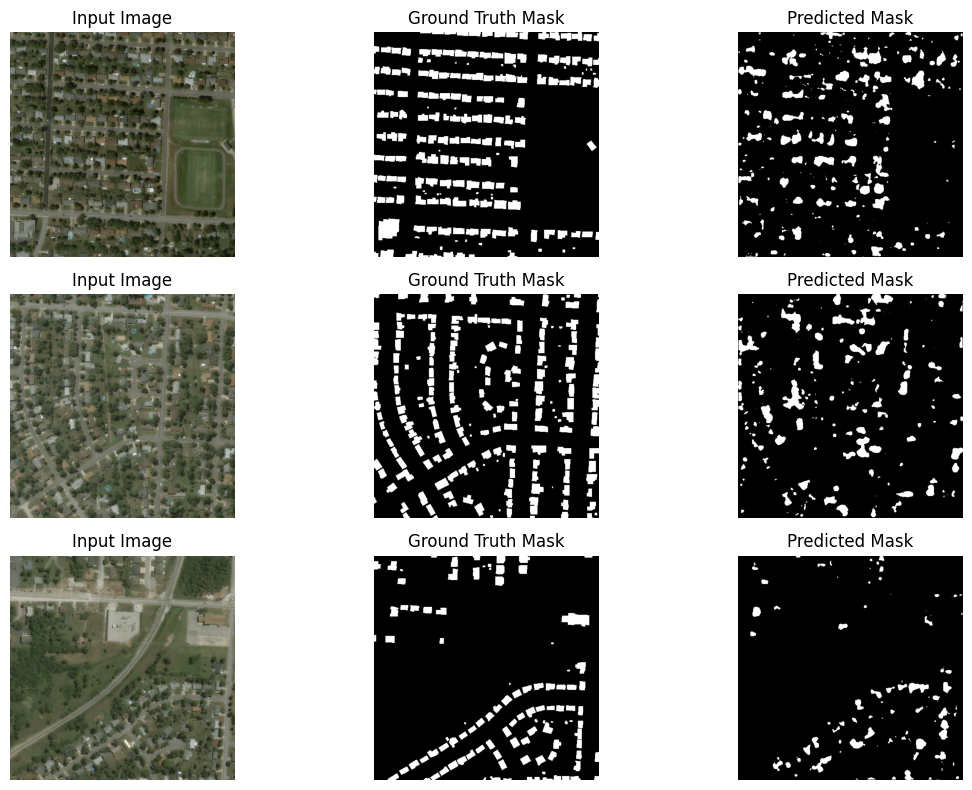

In [25]:
# ==== 1) Grab one batch from your TF dataset ====
sample_images, sample_masks = next(iter(dataset.take(1)))

# ==== 2) Run your model to get predicted masks ====
predicted_masks = model.predict(sample_images)

# ==== 3) Now visualize ====
import matplotlib.pyplot as plt

n = min(3, sample_images.shape[0])  # ensure we don’t go out of bounds
plt.figure(figsize=(12, 8))
for i in range(n):
    # Input image
    plt.subplot(n, 3, i*3 + 1)
    plt.imshow(sample_images[i])
    plt.title("Input Image")
    plt.axis("off")
    
    # Ground truth mask
    plt.subplot(n, 3, i*3 + 2)
    plt.imshow(sample_masks[i, ..., 0], cmap='gray')
    plt.title("Ground Truth Mask")
    plt.axis("off")
    
    # Predicted mask (thresholded)
    plt.subplot(n, 3, i*3 + 3)
    plt.imshow((predicted_masks[i, ..., 0] > 0.5), cmap='gray')
    plt.title("Predicted Mask")
    plt.axis("off")

plt.tight_layout()
plt.show()


In [26]:
# Define test dataset paths (adjust if needed)
TEST_BASE_PATH = "/kaggle/input/xbd-dataset/xbd/test"
TEST_IMAGES_PATH = os.path.join(TEST_BASE_PATH, "images")
TEST_MASKS_PATH = os.path.join(TEST_BASE_PATH, "masks")

# Filter only pre-disaster images in the test folder
test_image_names = sorted([fname for fname in os.listdir(TEST_IMAGES_PATH)
                            if (fname.endswith('.png') or fname.endswith('.jpg')) and "pre_disaster" in fname])
test_mask_names = sorted([fname for fname in os.listdir(TEST_MASKS_PATH)
                           if (fname.endswith('.png') or fname.endswith('.jpg')) and "pre_disaster" in fname])

# Find common file names between test images and test masks
test_common_names = sorted(list(set(test_image_names).intersection(set(test_mask_names))))
print("Number of common test files:", len(test_common_names))

# Create full paths for the test set
test_image_files = [os.path.join(TEST_IMAGES_PATH, fname) for fname in test_common_names]
test_mask_files = [os.path.join(TEST_MASKS_PATH, fname) for fname in test_common_names]

# Create test dataset using the same parsing and augmentation (you may skip augmentation during testing)
test_dataset = tf.data.Dataset.from_tensor_slices((test_image_files, test_mask_files))
test_dataset = test_dataset.map(parse_image_mask, num_parallel_calls=tf.data.AUTOTUNE)
# For testing, we usually do not apply augmentation.
test_dataset = test_dataset.batch(8).prefetch(tf.data.AUTOTUNE)

# Evaluate on the test dataset; this will output loss, accuracy, and f1_score_metric
test_results = model.evaluate(test_dataset)
print("Test results (loss, accuracy, F1 score):", test_results)


Number of common test files: 933
117/117 ━━━━━━━━━━━━━━━━━━━━ 32s 273ms/step - accuracy: 0.9327 - f1_score_loc: 0.3515 - loss: 1.1566 - xview2_score: 0.3515
Test results (loss, accuracy, F1 score): [1.0217628479003906, 0.9325839281082153, 0.35368937253952026, 0.35368937253952026]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


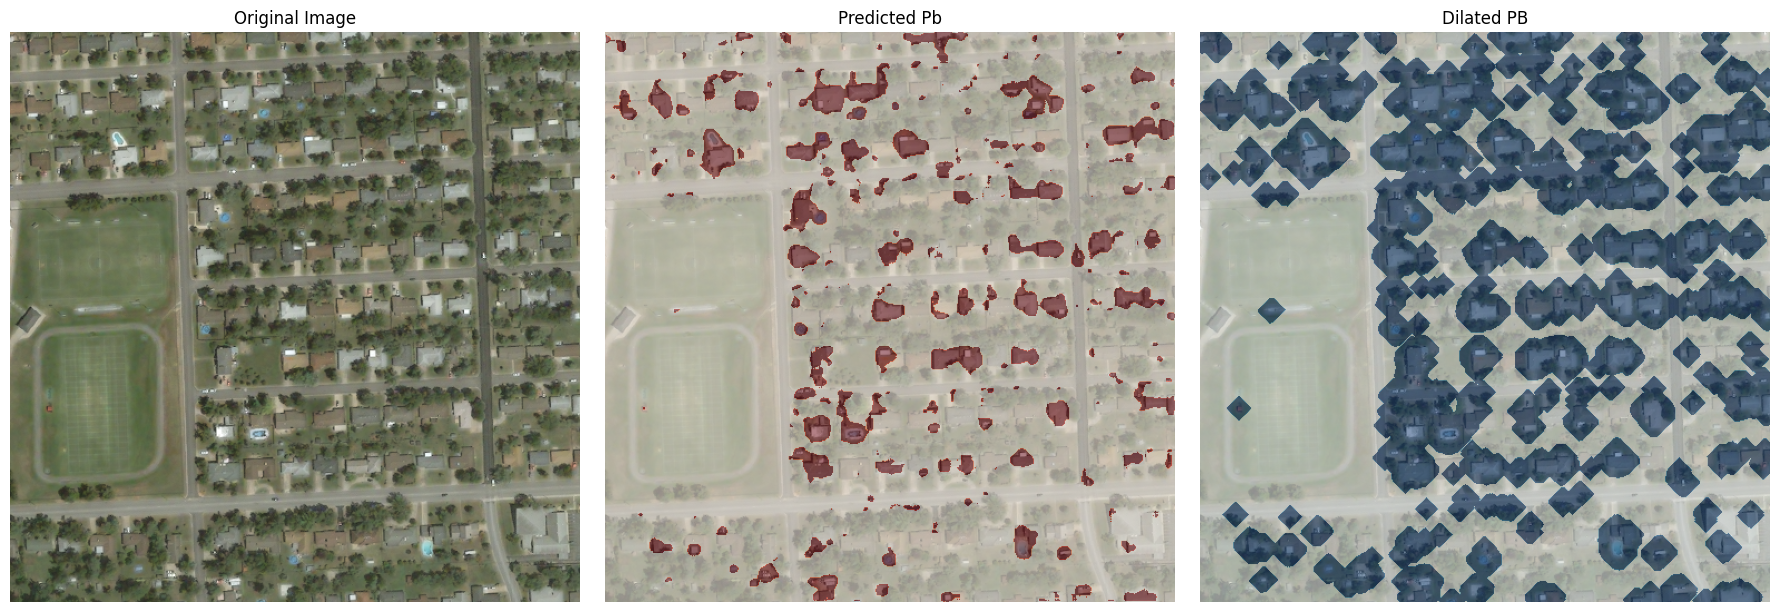

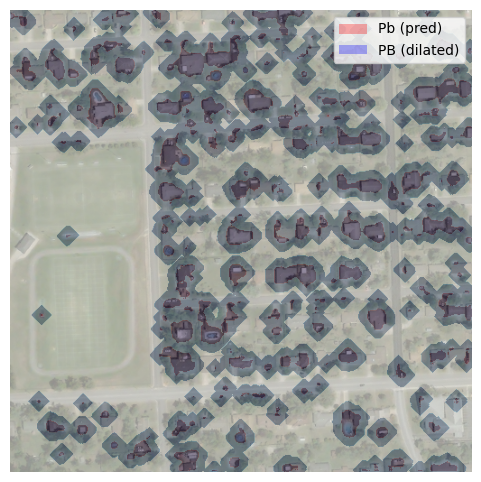

In [27]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage
from matplotlib.patches import Patch


def apply_morphological_dilation(binary_mask, dilation_pixels=10):
    """
    Apply morphological dilation to expand the building mask outward by specified pixels.
    Expects binary_mask as a 2-D array of 0/1.
    """
    # Use a simple 3×3 connectivity, then iterate
    struct_elem = ndimage.generate_binary_structure(2, 1)
    struct_elem = ndimage.iterate_structure(struct_elem, dilation_pixels)
    return ndimage.binary_dilation(binary_mask, structure=struct_elem).astype(np.uint8)

def visualize_dilation_effect(model, dataset):
    # Grab one batch
    for images, masks in dataset.take(1):
        preds = model.predict(images)  # shape: (N, H, W, 1)
        break

    # Only visualize the first example
    img = images[0].numpy()
    true_mask = masks[0,...,0].numpy().astype(np.uint8)
    pred_mask = (preds[0,...,0] > 0.5).astype(np.uint8)  # shape (H, W)

    dilated = apply_morphological_dilation(pred_mask, dilation_pixels=10)

    # Plot
    fig, axes = plt.subplots(1, 3, figsize=(18,6))
    axes[0].imshow(img)
    axes[0].set_title("Original Image"); axes[0].axis("off")

    axes[1].imshow(img); 
    axes[1].imshow(pred_mask, alpha=0.5, cmap="Reds")
    axes[1].set_title("Predicted Pb"); axes[1].axis("off")

    axes[2].imshow(img); 
    axes[2].imshow(dilated,   alpha=0.5, cmap="Blues")
    axes[2].set_title("Dilated PB"); axes[2].axis("off")

    plt.tight_layout()
    plt.show()

    # Overlay both masks
    fig, ax = plt.subplots(figsize=(6,6))
    ax.imshow(img)
    ax.imshow(pred_mask, alpha=0.3, cmap="Reds")
    ax.imshow(dilated,   alpha=0.3, cmap="Blues")
    ax.axis("off")
    legend_elems = [
        Patch(facecolor="red",   alpha=0.3, label="Pb (pred)"),
        Patch(facecolor="blue",  alpha=0.3, label="PB (dilated)")
    ]
    ax.legend(handles=legend_elems, loc="upper right")
    plt.show()

# Call it
visualize_dilation_effect(model, dataset)


## Stage 2

In [3]:

# GPU-Optimized Stage 2 Training Code

import tensorflow as tf
import numpy as np
import os

# Enable GPU memory growth to avoid allocation issues
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"✅ GPU memory growth enabled. Available GPUs: {len(gpus)}")
    except RuntimeError as e:
        print(f"GPU setup error: {e}")

# Verify GPU availability
print("GPU Available: ", tf.config.list_physical_devices('GPU'))
print("Built with CUDA: ", tf.test.is_built_with_cuda())

# Force TensorFlow to use GPU for all operations
with tf.device('/GPU:0'):
    print("✅ Using GPU for training")

✅ GPU memory growth enabled. Available GPUs: 1
GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Built with CUDA:  True
✅ Using GPU for training


In [15]:
# ===== Before building Stage 2 Siamese U-Net =====
# 1) Reconstruct the same encoder
shared_enc = encoder_model(input_shape=(512, 512, 3))

# 2) Load the pretrained Stage 1 encoder weights (no by_name=True anymore)
shared_enc.load_weights("/kaggle/working/stage1_encoder_weights.weights.h5")

print("✅ Loaded Stage 1 encoder weights into shared_enc.")

✅ Loaded Stage 1 encoder weights into shared_enc.


In [16]:
import os
import tensorflow as tf

# Define paths for Tier3 dataset (adjust BASE_PATH if necessary)
BASE_PATH = "/kaggle/input/xbd-dataset/xbd/tier3"
IMAGES_PATH = os.path.join(BASE_PATH, "images")
MASKS_PATH = os.path.join(BASE_PATH, "masks")

# List pre-disaster image filenames
pre_image_names = sorted([fname for fname in os.listdir(IMAGES_PATH)
                           if (fname.endswith('.png') or fname.endswith('.jpg')) and "pre_disaster" in fname])
# List mask filenames (ground truth building masks for pre-disaster)
mask_names = sorted([fname for fname in os.listdir(MASKS_PATH)
                     if (fname.endswith('.png') or fname.endswith('.jpg')) and "pre_disaster" in fname])

# Find common filenames between pre-disaster images and masks
common_names = sorted(list(set(pre_image_names).intersection(set(mask_names))))
print("Number of common pre-disaster files:", len(common_names))

# Create full paths for pre-disaster images and masks
pre_image_files = [os.path.join(IMAGES_PATH, fname) for fname in common_names]
mask_files = [os.path.join(MASKS_PATH, fname) for fname in common_names]
# Create corresponding post-disaster image file paths by replacing "pre_disaster" with "post_disaster"
post_image_files = [os.path.join(IMAGES_PATH, fname.replace("pre_disaster", "post_disaster")) for fname in common_names]



Number of common pre-disaster files: 6369


In [18]:
# ========== GPU-OPTIMIZED PREPROCESSING ==========
def gpu_optimized_slic_preprocessing(image):
    """
    GPU-optimized version of SLIC preprocessing using TensorFlow operations only
    This replaces the CPU-bound skimage operations
    """
    # Simple edge enhancement using Sobel filters (GPU-friendly alternative to SLIC)
    # Convert to grayscale for edge detection
    gray = tf.reduce_mean(image, axis=-1, keepdims=True)
    
    # Sobel edge detection kernels
    sobel_x = tf.constant([[-1., 0., 1.], [-2., 0., 2.], [-1., 0., 1.]], dtype=tf.float32)
    sobel_y = tf.constant([[-1., -2., -1.], [0., 0., 0.], [1., 2., 1.]], dtype=tf.float32)
    
    # Reshape kernels for conv2d
    sobel_x = tf.reshape(sobel_x, [3, 3, 1, 1])
    sobel_y = tf.reshape(sobel_y, [3, 3, 1, 1])
    
    # Apply Sobel filters
    edges_x = tf.nn.conv2d(tf.expand_dims(gray, 0), sobel_x, strides=[1, 1, 1, 1], padding='SAME')
    edges_y = tf.nn.conv2d(tf.expand_dims(gray, 0), sobel_y, strides=[1, 1, 1, 1], padding='SAME')
    
    # Combine edges
    edges = tf.sqrt(tf.square(edges_x) + tf.square(edges_y))
    edges = tf.squeeze(edges, 0)
    
    # Create enhanced image by combining original with edge information
    edges_3ch = tf.repeat(edges, 3, axis=-1)
    enhanced_image = 0.7 * image + 0.3 * edges_3ch
    enhanced_image = tf.clip_by_value(enhanced_image, 0.0, 1.0)
    
    # Create dummy segments (simple grid-based segmentation for GPU compatibility)
    h, w = tf.shape(image)[0], tf.shape(image)[1]
    y_coords = tf.range(h, dtype=tf.int32)
    x_coords = tf.range(w, dtype=tf.int32)
    yy, xx = tf.meshgrid(y_coords, x_coords, indexing='ij')
    
    # Create grid-based segments (16x16 pixel blocks)
    # Convert to float32 for division, then back to int32
    h_segments = tf.cast(w, tf.int32) // 16
    segments = (yy // 16) * h_segments + (xx // 16)
    segments = tf.cast(segments, tf.int32)
    
    return enhanced_image, segments

In [19]:
# Superpixel-based post-processing for damage classification
def superpixel_postprocessing(damage_pred, pre_segments, building_mask):
    """
    Apply superpixel-based post-processing to smooth damage classification results
    
    Args:
        damage_pred: Predicted damage classification (one-hot encoded)
        pre_segments: Superpixel segmentation of pre-disaster image
        building_mask: Binary mask indicating building locations
        
    Returns:
        refined_pred: Refined damage classification after superpixel voting
    """
    # Initialize refined prediction with same shape as input
    refined_pred = np.zeros_like(damage_pred)
    
    # Apply superpixel voting only within building mask
    building_pixels = building_mask > 0.5
    
    # For each superpixel in the pre-disaster image
    for segment_id in np.unique(pre_segments):
        # Create a mask for this superpixel
        sp_mask = pre_segments == segment_id
        
        # Only process superpixels that overlap with buildings
        if np.any(sp_mask & building_pixels):
            # For each damage class
            for c in range(damage_pred.shape[-1]):
                # Get votes for this class within the superpixel
                votes = damage_pred[sp_mask, c]
                
                if len(votes) > 0:
                    # Assign the majority vote to all pixels in this superpixel
                    # For soft voting, use the mean
                    refined_pred[sp_mask, c] = np.mean(votes)
    
    # Normalize to ensure the classes sum to 1
    class_sum = np.sum(refined_pred, axis=-1, keepdims=True)
    # Avoid division by zero
    class_sum = np.maximum(class_sum, 1e-10)
    refined_pred = refined_pred / class_sum
    
    return refined_pred

# Function to perform instance-level voting (for building instance consistency)
def instance_voting(damage_pred, building_instances):
    """
    Apply instance-level voting to ensure semantic consistency within building instances
    
    Args:
        damage_pred: Predicted damage classification (one-hot encoded)
        building_instances: Instance segmentation mask where each building has a unique ID
        
    Returns:
        instance_refined: Damage classification with consistent labels per building instance
    """
    instance_refined = np.zeros_like(damage_pred)
    
    # For each building instance
    for instance_id in np.unique(building_instances):
        # Skip background (usually labeled as 0)
        if instance_id == 0:
            continue
            
        # Create a mask for this building instance
        instance_mask = building_instances == instance_id
        
        # For each damage class
        for c in range(damage_pred.shape[-1]):
            # Get votes for this class within the instance
            votes = damage_pred[instance_mask, c]
            
            if len(votes) > 0:
                # Assign the majority vote to all pixels in this instance
                instance_refined[instance_mask, c] = np.mean(votes)
    
    # Normalize to ensure the classes sum to 1
    class_sum = np.sum(instance_refined, axis=-1, keepdims=True)
    # Avoid division by zero
    class_sum = np.maximum(class_sum, 1e-10)
    instance_refined = instance_refined / class_sum
    
    return instance_refined


In [21]:
@tf.function  # Compile to graph for better GPU performance
def parse_stage2_example_gpu(pre_path, post_path, mask_path):
    """
    GPU-optimized parsing function for Stage 2
    """
    # Read pre-disaster image
    pre_img = tf.io.read_file(pre_path)
    pre_img = tf.image.decode_image(pre_img, channels=3, expand_animations=False)
    pre_img.set_shape([None, None, 3])
    pre_img = tf.image.resize(pre_img, [512, 512])
    pre_img = tf.cast(pre_img, tf.float32) / 255.0
    
    # Read post-disaster image
    post_img = tf.io.read_file(post_path)
    post_img = tf.image.decode_image(post_img, channels=3, expand_animations=False)
    post_img.set_shape([None, None, 3])
    post_img = tf.image.resize(post_img, [512, 512])
    post_img = tf.cast(post_img, tf.float32) / 255.0
    
    # Read building mask
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_image(mask, channels=1, expand_animations=False)
    mask.set_shape([None, None, 1])
    mask = tf.image.resize(mask, [512, 512], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    mask = tf.cast(mask, tf.float32) / 255.0
    
    # Apply GPU-optimized preprocessing
    pre_enhanced, pre_segments = gpu_optimized_slic_preprocessing(pre_img)
    post_enhanced, post_segments = gpu_optimized_slic_preprocessing(post_img)
    
    # Concatenate original and enhanced images
    pre_combined = tf.concat([pre_img, pre_enhanced], axis=-1)
    post_combined = tf.concat([post_img, post_enhanced], axis=-1)
    
    # Load damage labels
    damage_path = tf.strings.regex_replace(post_path, "images", "masks")
    damage_raw = tf.io.read_file(damage_path)
    damage = tf.image.decode_image(damage_raw, channels=1, expand_animations=False)
    damage = tf.image.resize(damage, [512, 512], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    damage = tf.squeeze(tf.cast(damage, tf.int32), axis=-1)
    damage_gt = tf.one_hot(damage, depth=5, dtype=tf.float32)
    
    # Add channel dimension to segments
    pre_segments = tf.expand_dims(tf.cast(pre_segments, tf.float32), -1)
    post_segments = tf.expand_dims(tf.cast(post_segments, tf.float32), -1)
    
    return (pre_combined, post_combined, mask, pre_segments, post_segments), damage_gt

In [23]:
# ========== OPTIMIZED DATASET PIPELINE ==========
def create_optimized_dataset(pre_files, post_files, mask_files, batch_size=8):
    """
    Create highly optimized dataset pipeline for GPU training
    """
    # Create dataset from file paths
    dataset = tf.data.Dataset.from_tensor_slices((pre_files, post_files, mask_files))
    
    # Shuffle with a large buffer for better randomization
    dataset = dataset.shuffle(buffer_size=len(pre_files))
    
    # Map parsing function with parallel calls
    dataset = dataset.map(
        parse_stage2_example_gpu, 
        num_parallel_calls=tf.data.AUTOTUNE,
        deterministic=False  # Allow non-deterministic ordering for better performance
    )
    
    # Batch the data
    dataset = dataset.batch(batch_size, drop_remainder=True)
    
    # Cache after batching for better memory usage
    dataset = dataset.cache()
    
    # Repeat for multiple epochs
    dataset = dataset.repeat()
    
    # Prefetch to GPU memory
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    
    return dataset

In [24]:
# Create optimized dataset with smaller batch size for P100 GPU
BATCH_SIZE = 2  # Reduced for P100 memory constraints
stage2_dataset = create_optimized_dataset(pre_image_files, post_image_files, mask_files, BATCH_SIZE)

# Verify dataset works
print("Testing dataset pipeline...")
for batch in stage2_dataset.take(1):
    inputs, outputs = batch
    print("✅ Dataset pipeline working")
    print(f"Pre-disaster shape: {inputs[0].shape}")
    print(f"Post-disaster shape: {inputs[1].shape}")
    print(f"Mask shape: {inputs[2].shape}")
    print(f"Damage labels shape: {outputs.shape}")
    break

Testing dataset pipeline...
✅ Dataset pipeline working
Pre-disaster shape: (2, 512, 512, 6)
Post-disaster shape: (2, 512, 512, 6)
Mask shape: (2, 512, 512, 1)
Damage labels shape: (2, 512, 512, 5)


In [25]:
import tensorflow as tf
import numpy as np

# ======== Define a Custom ResizeLike Layer ===========
class ResizeLike(tf.keras.layers.Layer):
    def __init__(self, method="nearest", **kwargs):
        super(ResizeLike, self).__init__(**kwargs)
        self.method = method

    def call(self, inputs):
        # inputs: a list of two tensors [mask, target]
        mask, target = inputs
        
        # Get spatial dimensions from target
        target_shape = tf.shape(target)[1:3]
        
        # Resize the mask to match the target's spatial dimensions
        return tf.image.resize(mask, target_shape, method=self.method)

    def compute_output_shape(self, input_shape):
        # input_shape: list of two shapes: [mask_shape, target_shape]
        mask_shape, target_shape = input_shape
        return (mask_shape[0], target_shape[1], target_shape[2], mask_shape[3])


# ======== SSAM: Simple Self-Attention Module for Predisaster Features ===========
def ssam_module(x):
    """Applies a 1x1 convolution, computes an attention map with softmax, then reweights the feature map."""
    query = tf.keras.layers.Conv2D(x.shape[-1], (1, 1), padding='same')(x)
    attention = tf.keras.layers.Softmax(axis=1)(query)
    output = tf.keras.layers.Add()([x, tf.keras.layers.Multiply()([x, attention])])
    return output

# ======== CBAM: Convolutional Block Attention Module ===========
def cbam_module(x, ratio=8):
    channel = x.shape[-1]
    
    # Channel attention using GlobalAveragePooling2D and GlobalMaxPooling2D
    avg_pool = tf.keras.layers.GlobalAveragePooling2D()(x)
    avg_pool = tf.keras.layers.Reshape((1, 1, channel))(avg_pool)
    max_pool = tf.keras.layers.GlobalMaxPooling2D()(x)
    max_pool = tf.keras.layers.Reshape((1, 1, channel))(max_pool)
    
    shared_dense_one = tf.keras.layers.Dense(channel // ratio, activation='relu',
                                             kernel_initializer='he_normal', use_bias=True)
    shared_dense_two = tf.keras.layers.Dense(channel, kernel_initializer='he_normal', use_bias=True)
    avg_out = shared_dense_two(shared_dense_one(avg_pool))
    max_out = shared_dense_two(shared_dense_one(max_pool))
    channel_attention = tf.keras.layers.Activation('sigmoid')(tf.keras.layers.Add()([avg_out, max_out]))
    x_channel_refined = tf.keras.layers.Multiply()([x, channel_attention])
    
    # Spatial attention using Lambda layers
    avg_pool_spatial = tf.keras.layers.Lambda(lambda z: tf.reduce_mean(z, axis=-1, keepdims=True))(x_channel_refined)
    max_pool_spatial = tf.keras.layers.Lambda(lambda z: tf.reduce_max(z, axis=-1, keepdims=True))(x_channel_refined)
    concat = tf.keras.layers.Concatenate(axis=-1)([avg_pool_spatial, max_pool_spatial])
    spatial_attention = tf.keras.layers.Conv2D(1, (7,7), padding='same', 
                                               activation='sigmoid', 
                                               kernel_initializer='he_normal',
                                               use_bias=False)(concat)
    refined = tf.keras.layers.Multiply()([x_channel_refined, spatial_attention])
    return refined


# ======== Differential Attention Module (DAM) ===========
def differential_attention_module(f_pre, f_post, mask=None, use_ssam=True):
    """
    Computes the difference between predisaster and postdisaster features,
    refines it using CBAM, optionally applies SSAM on the predisaster branch,
    and fuses the predisaster, differential, and postdisaster features.
    """
    # Compute raw difference
    diff_raw = tf.keras.layers.Subtract()([f_pre, f_post])
    
    # Refine the difference using CBAM
    diff_refined = cbam_module(diff_raw)
    
    # Optionally refine predisaster features using SSAM
    f_pre_refined = ssam_module(f_pre) if use_ssam else f_pre
    
    # If a building mask is provided, resize it to the shape of diff_refined using our custom layer.
    if mask is not None:
        mask_resized = ResizeLike(method="nearest")([mask, diff_refined])
        diff_refined = tf.keras.layers.Multiply()([diff_refined, mask_resized])
    
    # Fuse predisaster, refined difference, and postdisaster features.
    fused_pre = tf.keras.layers.Conv2D(f_pre_refined.shape[-1], (1, 1), padding='same')(f_pre_refined)
    fused_diff = tf.keras.layers.Conv2D(f_pre_refined.shape[-1], (1, 1), padding='same')(diff_refined)
    fused_post = tf.keras.layers.Conv2D(f_pre_refined.shape[-1], (1, 1), padding='same')(f_post)
    fused = tf.keras.layers.Add()([fused_pre, fused_diff, fused_post])
    return fused


# ======== Shared Encoder Model ===========
def encoder_model(input_shape=(512, 512, 6)):  # Changed to 6 channels for SLIC-enhanced input
    inputs = tf.keras.Input(shape=input_shape)
    # Assuming encoder_block and conv_block functions are defined elsewhere
    s1, p1 = encoder_block(inputs, 64, dropout_rate=0.1)
    s2, p2 = encoder_block(p1, 128, dropout_rate=0.1)
    s3, p3 = encoder_block(p2, 256, dropout_rate=0.2)
    s4, p4 = encoder_block(p3, 512, dropout_rate=0.2)
    bottleneck = conv_block(p4, 1024)
    model = tf.keras.Model(inputs, [s1, s2, s3, s4, bottleneck], name="encoder")
    return model


def siamese_unet_damage_model(input_size=(512, 512, 6), mask_size=(512, 512, 1), num_classes=5):
    """
    PCDASNet model with simpler implementation
    """
    # Inputs: predisaster, postdisaster (both with SLIC enhancement), building mask, and segments
    pre_input = tf.keras.Input(shape=input_size, name="pre_disaster_input")
    post_input = tf.keras.Input(shape=input_size, name="post_disaster_input")
    mask_input = tf.keras.Input(shape=mask_size, name="building_mask_input")
    pre_segments_input = tf.keras.Input(shape=(512, 512, 1), name="pre_segments_input")
    post_segments_input = tf.keras.Input(shape=(512, 512, 1), name="post_segments_input")
    
    # Simply use the mask directly - no dilation for now
    # We can add it later once the model is working
    dilated_mask = mask_input
    
    # Shared encoder (using weights from Stage 1)
    shared_enc = encoder_model(input_shape=input_size)
    s1_pre, s2_pre, s3_pre, s4_pre, b_pre = shared_enc(pre_input)
    s1_post, s2_post, s3_post, s4_post, b_post = shared_enc(post_input)
    
    # Apply the Differential Attention Module (shallow DAM) at each encoder level.
    skip1 = differential_attention_module(s1_pre, s1_post, mask=dilated_mask, use_ssam=True)
    skip2 = differential_attention_module(s2_pre, s2_post, mask=dilated_mask, use_ssam=True)
    skip3 = differential_attention_module(s3_pre, s3_post, mask=dilated_mask, use_ssam=True)
    skip4 = differential_attention_module(s4_pre, s4_post, mask=dilated_mask, use_ssam=True)
    
    # At the bottleneck, apply deep DAM (without SSAM) for high-level features.
    bottleneck_diff = cbam_module(tf.keras.layers.Subtract()([b_pre, b_post]))
    bottleneck_fused = tf.keras.layers.Add()([b_pre, bottleneck_diff, b_post])
    
    # Decoder (using decoder_block from Stage 1)
    d1 = decoder_block(bottleneck_fused, skip4, 512)
    d2 = decoder_block(d1, skip3, 256)
    d3 = decoder_block(d2, skip2, 128)
    d4 = decoder_block(d3, skip1, 64)
    
    # Final output: multi-class damage classification map with softmax activation.
    damage_logits = tf.keras.layers.Conv2D(num_classes, (1, 1), padding='same')(d4)
    damage_probs = tf.keras.layers.Softmax(axis=-1)(damage_logits)
    
    # Simply use the probabilities directly - no superpixel processing for now
    # We can add it later once the model is working
    refined_output = damage_probs
    
    model = tf.keras.Model(
        inputs=[pre_input, post_input, mask_input, pre_segments_input, post_segments_input], 
        outputs=refined_output, 
        name="PCDASNet"
    )
    return model

damage_model = siamese_unet_damage_model()
damage_model.summary()


Model: "PCDASNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ pre_disaster_input        │ (None, 512, 512, 6)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ post_disaster_input       │ (None, 512, 512, 6)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder (Functional)      │ [(None, 512, 512, 64), │     18,860,800 │ pre_disaster_input[0]… │
│                           │ (None, 256, 256, 128), │                │ post_disaster_input[0… │
│                           │ (None, 128, 128, 256), │                │                        │
│                           │ (None, 64, 64, 512),   │                │                        │
│                           │ (None, 32, 32, 1024)]  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ subtract_3 (Subtract)     │ (None, 64, 64, 512)    │              0 │ encoder[0][3],         │
│                           │                        │                │ encoder[1][3]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 512)            │              0 │ subtract_3[0][0]       │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling2d_3    │ (None, 512)            │              0 │ subtract_3[0][0]       │
│ (GlobalMaxPooling2D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ subtract_4 (Subtract)     │ (None, 32, 32, 1024)   │              0 │ encoder[0][4],         │
│                           │                        │                │ encoder[1][4]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_6 (Reshape)       │ (None, 1, 1, 512)      │              0 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_7 (Reshape)       │ (None, 1, 1, 512)      │              0 │ global_max_pooling2d_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 1024)           │              0 │ subtract_4[0][0]       │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling2d_4    │ (None, 1024)           │              0 │ subtract_4[0][0]       │
│ (GlobalMaxPooling2D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 1, 1, 64)       │         32,832 │ reshape_6[0][0],       │
│                           │                        │                │ reshape_7[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_8 (Reshape)       │ (None, 1, 1, 1024)     │              0 │ global_average_poolin… │
├──────────────────────

 Total params: 32,805,671 (125.14 MB)

 Trainable params: 32,793,895 (125.10 MB)

 Non-trainable params: 11,776 (46.00 KB)

In [27]:
# CELL 2: Dataset Optimization Functions
# ======== Dataset Pipeline Optimization ===========
def optimize_dataset(dataset, batch_size=16, cache=True, prefetch=True):
    """
    Optimize dataset pipeline for better GPU utilization
    - batch_size: Number of samples per batch
    - cache: Whether to cache the dataset
    - prefetch: Whether to prefetch data
    """
    # Apply batching if the dataset is not already batched
    if hasattr(dataset, '_batch_size') and dataset._batch_size is None:
        dataset = dataset.batch(batch_size)
    
    # Cache dataset if requested
    if cache:
        dataset = dataset.cache()
    
    # Prefetch data to overlap data preprocessing and model execution
    if prefetch:
        AUTOTUNE = tf.data.AUTOTUNE
        dataset = dataset.prefetch(AUTOTUNE)
    
    return dataset

# Custom preprocessing transformation (keeping your original code)
def add_channel_dimension(inputs, outputs):
    pre_input, post_input, mask_input, pre_segments, post_segments = inputs
    
    # Add channel dimension to segments and ensure they're float32
    pre_segments = tf.expand_dims(pre_segments, -1)
    pre_segments = tf.cast(pre_segments, tf.float32)
    
    post_segments = tf.expand_dims(post_segments, -1)
    post_segments = tf.cast(post_segments, tf.float32)
    
    # Return modified inputs and unchanged outputs
    return (pre_input, post_input, mask_input, pre_segments, post_segments), outputs

# Apply transformations to dataset and optimize it
# REPLACE your existing dataset preparation with this
stage2_dataset = stage2_dataset.map(add_channel_dimension)

# Optimize dataset pipeline for GPU
stage2_dataset = optimize_dataset(stage2_dataset, batch_size=16)  # Adjust batch size based on your GPU memory

# Verify the shapes are correct
for batch in stage2_dataset.take(1):
    inputs, outputs = batch
    print("Pre-segments shape:", inputs[3].shape)
    print("Post-segments shape:", inputs[4].shape)
    print("Batch size:", inputs[0].shape[0])

Pre-segments shape: (2, 512, 512, 1, 1)
Post-segments shape: (2, 512, 512, 1, 1)
Batch size: 2


In [28]:
import tensorflow as tf
import numpy as np

# ======== Loss Functions for Multi-Class Damage Classification ========
def dice_loss_multiclass(y_true, y_pred, smooth=1):
    y_true_f = tf.reshape(y_true, [-1, tf.shape(y_true)[-1]])
    y_pred_f = tf.reshape(y_pred, [-1, tf.shape(y_pred)[-1]])
    intersection = tf.reduce_sum(y_true_f * y_pred_f, axis=0)
    dice = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f, axis=0) + tf.reduce_sum(y_pred_f, axis=0) + smooth)
    return 1 - tf.reduce_mean(dice)

def focal_loss_multiclass(y_true, y_pred, gamma=2.0, alpha=0.25, epsilon=1e-7):
    y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
    cross_entropy = -y_true * tf.math.log(y_pred)
    loss = alpha * tf.pow(1 - y_pred, gamma) * cross_entropy
    return tf.reduce_mean(loss)

def combined_loss_multiclass(y_true, y_pred):
    cce = tf.keras.losses.CategoricalCrossentropy()(y_true, y_pred)
    d_loss = dice_loss_multiclass(y_true, y_pred)
    f_loss = focal_loss_multiclass(y_true, y_pred)
    return 0.3 * d_loss + 0.3 * f_loss + 0.4 * cce

# ======== Metrics for xView2 Damage Classification ========
def f1_score_cls(y_true, y_pred, class_idx, threshold=0.5, smooth=1e-7):
    """
    Calculate F1 score for a specific damage class (F1cls) as per xView2 challenge
    """
    # Extract the specific class from one-hot encoded tensors
    y_true_class = y_true[..., class_idx]
    y_pred_class = y_pred[..., class_idx]
    
    # Threshold predictions
    y_pred_bin = tf.cast(y_pred_class > threshold, tf.float32)
    
    # True positives, false positives, false negatives
    tp = tf.reduce_sum(y_true_class * y_pred_bin)
    fp = tf.reduce_sum(y_pred_bin) - tp
    fn = tf.reduce_sum(y_true_class) - tp
    
    # Calculate precision and recall
    precision = tp / (tp + fp + smooth)
    recall = tp / (tp + fn + smooth)
    
    # Calculate F1 score
    f1 = 2 * precision * recall / (precision + recall + smooth)
    
    return f1

# Create F1 score metrics for each damage class (assuming 4 damage classes)
# Update the number of classes if different
def f1_cls0(y_true, y_pred):
    return f1_score_cls(y_true, y_pred, 0)

def f1_cls1(y_true, y_pred):
    return f1_score_cls(y_true, y_pred, 1)

def f1_cls2(y_true, y_pred):
    return f1_score_cls(y_true, y_pred, 2)

def f1_cls3(y_true, y_pred):
    return f1_score_cls(y_true, y_pred, 3)

# Calculate the weighted xView2 score for damage classification
# Assuming F1loc is provided from stage 1 (building localization)
# Calculate the weighted xView2 score for damage classification
def xview2_score_damage(y_true, y_pred, f1loc=None):
    """
    Calculate xView2 weighted score: 0.3 * F1loc + 0.7 * avg(F1cls)
    If F1loc is not provided, only calculate the damage classification component
    """
    # Get the number of classes (must be a fixed value for TensorFlow metrics)
    # Assuming 4 damage classes - modify this number if you have a different number of classes
    num_classes = 4  # Replace with your actual number of classes
    
    # Calculate F1 scores for each damage class
    f1_scores = []
    for i in range(num_classes):
        f1_cls = f1_score_cls(y_true, y_pred, i)
        f1_scores.append(f1_cls)
    
    # Average F1 score across all damage classes
    avg_f1_cls = tf.reduce_mean(tf.stack(f1_scores))
    
    # If F1loc is provided, calculate the complete weighted score
    if f1loc is not None:
        return 0.3 * f1loc + 0.7 * avg_f1_cls
    
    # Otherwise, return just the damage classification component
    return avg_f1_cls


In [29]:
# ========== GPU-OPTIMIZED MODEL COMPILATION ==========
with tf.device('/GPU:0'):
    # Create the model
    damage_model_gpu = siamese_unet_damage_model()
    
    # Use mixed precision for better GPU utilization
    policy = tf.keras.mixed_precision.Policy('mixed_float16')
    tf.keras.mixed_precision.set_global_policy(policy)
    print("✅ Mixed precision enabled")
    
    # Compile with GPU-optimized settings
    damage_model_gpu.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss=combined_loss_multiclass,
        metrics=["accuracy", f1_cls0, f1_cls1, f1_cls2, f1_cls3, xview2_score_damage],
        run_eagerly=False  # Ensure graph mode for better GPU performance
    )

✅ Mixed precision enabled


In [ ]:
# ========== TRAINING CONFIGURATION ==========
# Calculate steps per epoch
STEPS_PER_EPOCH = len(pre_image_files) // BATCH_SIZE
print(f"Steps per epoch: {STEPS_PER_EPOCH}")

# GPU-optimized callbacks
callbacks_gpu = [
    tf.keras.callbacks.EarlyStopping(
        monitor='xview2_score_damage', 
        patience=5, 
        mode='max', 
        restore_best_weights=True,
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='loss', 
        factor=0.5, 
        patience=3, 
        verbose=1,
        min_lr=1e-7
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath='/kaggle/working/best_stage2_model.keras',
        monitor='xview2_score_damage',
        mode='max',
        save_best_only=True,
        save_weights_only=False,
        verbose=1
    ),
    # Add TensorBoard callback for monitoring GPU usage
    tf.keras.callbacks.TensorBoard(
        log_dir='/kaggle/working/logs',
        histogram_freq=1,
        profile_batch='10,20'  # Profile batches 10-20 for performance analysis
    )
]

# ========== START TRAINING ==========
print("🚀 Starting GPU training...")
print(f"Using batch size: {BATCH_SIZE}")
print(f"Steps per epoch: {STEPS_PER_EPOCH}")

# Force GPU usage and start training
with tf.device('/GPU:0'):
    history_stage2_gpu = damage_model_gpu.fit(
        stage2_dataset,
        epochs=2,  # Increased epochs since dataset is optimized
        steps_per_epoch=STEPS_PER_EPOCH,
        callbacks=callbacks_gpu,
        verbose=1
    )

print("✅ Training completed!")

# ========== SAVE MODEL ==========
damage_model_gpu.save('/kaggle/working/stage2_gpu_model.keras')
damage_model_gpu.save_weights('/kaggle/working/stage2_gpu_model_weights.h5')
print("✅ Model and weights saved!")

# ========== MONITOR GPU USAGE ==========
def check_gpu_usage():
    """
    Check current GPU memory usage
    """
    try:
        import subprocess
        result = subprocess.run(['nvidia-smi', '--query-gpu=memory.used,memory.total', '--format=csv,nounits,noheader'], 
                               capture_output=True, text=True)
        if result.returncode == 0:
            lines = result.stdout.strip().split('\n')
            for i, line in enumerate(lines):
                used, total = line.split(', ')
                usage_percent = (int(used) / int(total)) * 100
                print(f"GPU {i}: {used}MB / {total}MB ({usage_percent:.1f}%)")
    except:
        print("Could not check GPU usage")

# Check GPU usage after training
print("\n📊 GPU Usage After Training:")
check_gpu_usage()

Steps per epoch: 3184
🚀 Starting GPU training...
Using batch size: 2
Steps per epoch: 3184
Epoch 1/2
 397/3184 ━━━━━━━━━━━━━━━━━━━━ 18:01 388ms/step - accuracy: 0.7337 - f1_cls0: 0.6358 - f1_cls1: 0.0313 - f1_cls2: 0.0016 - f1_cls3: 0.0014 - loss: 0.6318 - xview2_score_damage: 0.1675

In [ ]:
# ======== Visualization and Evaluation ========
import matplotlib.pyplot as plt

# Plot training history
def plot_training_history(history):
    fig, axes = plt.subplots(1, 2, figsize=(20, 5))
    
    # Plot loss
    axes[0].plot(history.history['loss'], label='loss')
    if 'val_loss' in history.history:
        axes[0].plot(history.history['val_loss'], label='val_loss')
    axes[0].set_title('Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].legend()
    
    # Plot metrics
    for metric in history.history:
        if metric != 'loss' and metric != 'val_loss' and metric != 'lr':
            axes[1].plot(history.history[metric], label=metric)
    axes[1].set_title('Metrics')
    axes[1].set_xlabel('Epoch')
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()

# Visualize SLIC segmentation results
def visualize_slic_results(image, segments):
    """
    Visualize SLIC segmentation results
    """
    # Create a figure with 1 row and 3 columns
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Original image
    axes[0].imshow(image)
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    
    # SLIC segmentation
    axes[1].imshow(label2rgb(segments, image, kind='avg'))
    axes[1].set_title('SLIC Segmentation')
    axes[1].axis('off')
    
    # SLIC boundaries
    axes[2].imshow(image)
    
    # Create a mask for the segment boundaries
    from skimage.segmentation import mark_boundaries
    marked = mark_boundaries(image, segments)
    axes[2].imshow(marked)
    axes[2].set_title('SLIC Boundaries')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize the effect of SLIC preprocessing
def visualize_slic_preprocessing(dataset):
    """
    Visualize the effect of SLIC preprocessing on images
    """
    # Get one batch from the dataset
    for (pre_imgs, post_imgs, masks, pre_segments, post_segments), _ in dataset.take(1):
        break
    
    # Get the first image in the batch
    pre_img = pre_imgs[0].numpy()
    post_img = post_imgs[0].numpy()
    pre_seg = pre_segments[0].numpy()
    post_seg = post_segments[0].numpy()
    
    # Split the combined images (original + SLIC enhanced)
    pre_original = pre_img[:, :, :3]
    pre_enhanced = pre_img[:, :, 3:]
    post_original = post_img[:, :, :3]
    post_enhanced = post_img[:, :, 3:]
    
    # Visualize pre-disaster image and its SLIC segmentation
    print("Pre-disaster image with SLIC segmentation:")
    visualize_slic_results(pre_original, pre_seg)
    
    # Visualize post-disaster image and its SLIC segmentation
    print("Post-disaster image with SLIC segmentation:")
    visualize_slic_results(post_original, post_seg)
    
    # Compare original and SLIC-enhanced images
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # Pre-disaster original
    axes[0, 0].imshow(pre_original)
    axes[0, 0].set_title('Pre-disaster Original')
    axes[0, 0].axis('off')
    
    # Pre-disaster SLIC enhanced
    axes[0, 1].imshow(pre_enhanced)
    axes[0, 1].set_title('Pre-disaster SLIC Enhanced')
    axes[0, 1].axis('off')
    
    # Post-disaster original
    axes[1, 0].imshow(post_original)
    axes[1, 0].set_title('Post-disaster Original')
    axes[1, 0].axis('off')
    
    # Post-disaster SLIC enhanced
    axes[1, 1].imshow(post_enhanced)
    axes[1, 1].set_title('Post-disaster SLIC Enhanced')
    axes[1, 1].axis('off')
    
    plt.tight_layout()
    plt.show()

# Call the visualization function
visualize_slic_preprocessing(stage2_dataset)

# Plot training history
plot_training_history(history_stage2)


In [ ]:
# Visualize damage classification results
def visualize_damage_classification(model, dataset, num_samples=2):
    """
    Visualize damage classification results
    """
    # Get a batch from the dataset
    for (pre_imgs, post_imgs, masks, pre_segments, post_segments), damage_gt in dataset.take(1):
        break
    
    # Make predictions
    predictions = model.predict([pre_imgs[:num_samples], post_imgs[:num_samples], 
                                masks[:num_samples], pre_segments[:num_samples], 
                                post_segments[:num_samples]])
    
    # Define class names and colors
    class_names = ['No Damage', 'Minor Damage', 'Major Damage', 'Destroyed', 'Background']
    class_colors = ['green', 'yellow', 'orange', 'red', 'blue']
    
    # Create a figure
    fig, axes = plt.subplots(num_samples, 4, figsize=(20, 5*num_samples))
    
    for i in range(num_samples):
        # Pre-disaster image
        axes[i, 0].imshow(pre_imgs[i, :, :, :3])
        axes[i, 0].set_title('Pre-disaster Image')
        axes[i, 0].axis('off')
        
        # Post-disaster image
        axes[i, 1].imshow(post_imgs[i, :, :, :3])
        axes[i, 1].set_title('Post-disaster Image')
        axes[i, 1].axis('off')
        
        # Building mask
        axes[i, 2].imshow(pre_imgs[i, :, :, :3])
        axes[i, 2].imshow(masks[i, :, :, 0], alpha=0.5, cmap='Blues')
        axes[i, 2].set_title('Building Mask')
        axes[i, 2].axis('off')
        
        # Damage classification
        axes[i, 3].imshow(post_imgs[i, :, :, :3])
        
        # Get the class with highest probability for each pixel
        pred_class = np.argmax(predictions[i], axis=-1)
        
        # Create a color-coded damage map
        damage_map = np.zeros((512, 512, 4))  # RGBA
        
        # Only show damage classification within building mask
        building_pixels = masks[i, :, :, 0] > 0.5
        
        for c in range(len(class_names)-1):  # Exclude background
            class_mask = (pred_class == c) & building_pixels
            if np.any(class_mask):
                # Convert class color to RGBA
                from matplotlib.colors import to_rgba
                rgba = to_rgba(class_colors[c], alpha=0.6)
                
                # Set the color for this class
                for ch in range(4):
                    damage_map[:, :, ch] = np.where(class_mask, rgba[ch], damage_map[:, :, ch])
        
        axes[i, 3].imshow(damage_map)
        axes[i, 3].set_title('Damage Classification')
        axes[i, 3].axis('off')
        
        # Add a legend
        from matplotlib.patches import Patch
        legend_elements = [Patch(facecolor=class_colors[c], alpha=0.6, label=class_names[c]) 
                          for c in range(len(class_names)-1)]  # Exclude background
        axes[i, 3].legend(handles=legend_elements, loc='upper right')
    
    plt.tight_layout()
    plt.show()

# Call the visualization function
visualize_damage_classification(damage_model, stage2_dataset)


## 

## Shallow DAMs for Skip Connections:
For each level of the encoder’s output (s1 through s4), the Differential Attention Module computes:

Difference of Features: The raw difference between pre‑ and post‑disaster features.

Attention Refinement: This difference is refined using the CBAM (which applies channel and spatial attention).

SSAM Application: The predisaster branch is further processed with a Simple Self-Attention Module (SSAM) to capture fine-grained details.

Mask Integration: The building mask is incorporated (via element-wise multiplication after appropriate resizing) to constrain the network’s attention on building regions.

Fusion: Finally, the refined difference is fused with the origi* nal predisaster and post‑disaster features.

The outputs (skip1–skip4) will be used as skip connections in the decoder to provide spatial details that have been differentially processed.

## Deep DAM for High-Level Features:
At the bottleneck, the network computes the difference between high-level predisaster and post-disaster features.

No SSAM Here: At this depth, fine-grained details are less critical, so SSAM is not applied.

Refinement with CBAM: The raw difference undergoes CBAM refinement.

Fusion: The refined difference is then fused (via element-wise addition) with both the predisaster and post‑disaster bottleneck features to produce a combined high-level representation.